## Importing Libraries






In [1]:
import os
import cv2
import matplotlib.pyplot as plt
from roboflow import Roboflow
import yaml

### Loading Dataset From Roboflow

After manually annotating the images on roboflow, download the annotated images from the roboflow.

In [20]:
!pip install roboflow

In [2]:
rf = Roboflow(api_key="6EiI7GonFBAg0QFdjdAn")
project = rf.workspace("abc-m0ngq").project("image-annotation-xvorl")
version = project.version(2)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...


In [3]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


NOTE: We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the data.yaml file, ensuring it correctly points to the subdirectories for your dataset's train and valid subsets.

In [4]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [5]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 115
names: ['BP monitor', 'Indoor Plant', 'action figure', 'air conditioner', 'air purifier', 'alarm clock', 'alcohol', 'badminton racket', 'bag', 'basketball', 'battery', 'bed', 'belt', 'blanket', 'board game', 'bobby pin', 'book', 'bookshelf', 'broken socket', 'brush', 'cabinet', 'camera', 'candle', 'car', 'carpet', 'chair', 'charger', 'cleaning chemical', 'clock', 'coin', 'cryon', 'curtain', 'diaper station', 'doll', 'door', 'dressing table', 'dumbell', 'dustbin', 'electric razor', 'electric wire', 'emergency alarm', 'fairy lights', 'fan', 'file', 'flower', 'football', 'fridge', 'game console', 'gaming chair', 'glass shard', 'hair curler', 'hair dryer', 'hair straightener', 'handbag', 'hearing aid', 'heater', 'heel', 'jewelry box', 'journal', 'knife', 'knitting', 'lamp', 'laptop', 'leather shoes', 'lego', 'light', 'lighter', 'lipstick', 'makeup', 'markers', 'mat', 'medicine', 'mirror', 'nail polish', 'nails', 'nee

In [6]:
# The dataset path is stored in 'dataset.location'
dataset_path = dataset.location  # This gives the downloaded folder path

# Paths to training and testing images
train_path = os.path.join(dataset_path, "train", "images")
valid_path = os.path.join(dataset_path, "valid", "images")
test_path = os.path.join(dataset_path, "test", "images")

In [7]:
train_labels_path = os.path.join(dataset_path, "train", "labels")
valid_labels_path = os.path.join(dataset_path, "valid", "labels")
test_labels_path = os.path.join(dataset_path, "test", "labels")

In [8]:
yaml_path = os.path.join(dataset_path, "data.yaml")  # Path to YAML file

# Read class names from data.yaml
with open(yaml_path, "r") as file:
    data = yaml.safe_load(file)
    class_names = data["names"]  # Extract class names

# Print class names
print("Class Names:", class_names)
# Number of Classes
print(len(class_names))

Class Names: ['BP monitor', 'Indoor Plant', 'action figure', 'air conditioner', 'air purifier', 'alarm clock', 'alcohol', 'badminton racket', 'bag', 'basketball', 'battery', 'bed', 'belt', 'blanket', 'board game', 'bobby pin', 'book', 'bookshelf', 'broken socket', 'brush', 'cabinet', 'camera', 'candle', 'car', 'carpet', 'chair', 'charger', 'cleaning chemical', 'clock', 'coin', 'cryon', 'curtain', 'diaper station', 'doll', 'door', 'dressing table', 'dumbell', 'dustbin', 'electric razor', 'electric wire', 'emergency alarm', 'fairy lights', 'fan', 'file', 'flower', 'football', 'fridge', 'game console', 'gaming chair', 'glass shard', 'hair curler', 'hair dryer', 'hair straightener', 'handbag', 'hearing aid', 'heater', 'heel', 'jewelry box', 'journal', 'knife', 'knitting', 'lamp', 'laptop', 'leather shoes', 'lego', 'light', 'lighter', 'lipstick', 'makeup', 'markers', 'mat', 'medicine', 'mirror', 'nail polish', 'nails', 'needle', 'page', 'paint thinner', 'painting', 'painting kit', 'paper', 

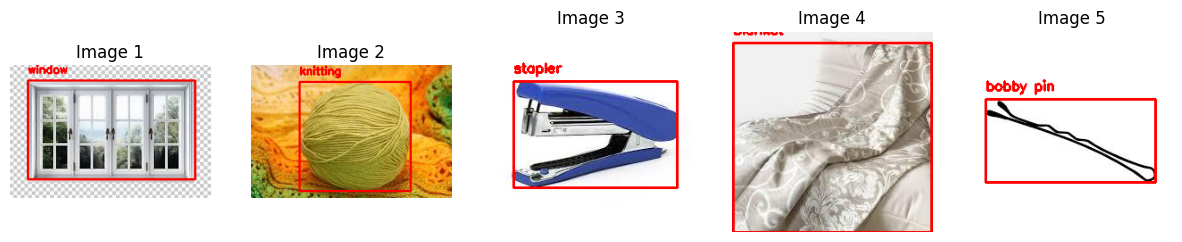

In [10]:
# Get list of image files
train_images = [f for f in os.listdir(train_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

#  Function to draw bounding boxes
def draw_bboxes(img, label_path):
    h, w, _ = img.shape  # Get image dimensions

    # Check if label file exists
    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            labels = file.readlines()

        for label in labels:
            label_info = label.strip().split()
            class_id = int(label_info[0])  # First value is class ID
            x_center, y_center, box_w, box_h = map(float, label_info[1:])

            # Convert YOLO format (normalized) to pixel values
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)

            # Draw bounding box
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

            # Put class label
            class_label = class_names[class_id]  # Get class name from YAML
            cv2.putText(img, class_label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return img

#  Display multiple images with labels
num_images = min(5, len(train_images))  # Display up to 5 images
plt.figure(figsize=(15, 8))

for i in range(num_images):
    img_name = train_images[i]
    img_path = os.path.join(train_path, img_name)
    label_path = os.path.join(train_labels_path, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    img = draw_bboxes(img, label_path)

    # Display image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Image {i+1}")

plt.show()

As the dataset is small and there can be multiple objects per image so we will use lighter version of the yolov12 that will perform well and will give better accuracy. Similarly, as the dataset is small we will perform some data augmentation techniques to make our model able to detect objects in various scenerios and under different conditions and make it possible for it to detect the smaller objects as accurate as possibe.


*   Mosaic : (Combines multiple images to help detect small objects.)
* MixUp : (Blends two images to improve robustness.)
* Copy-Paste :  (Adds objects from one image to another, good for object detection.)
* Scale : (Randomly scales images to improve object size variance.)
* Horizontal Flip : (Helps with natural variations in indoor scenes.)
* Color Jitter : (Adjusts brightness, contrast, and saturation.)



### YOLOV12 Model:

In [11]:
!pip install ultralytics

In [9]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### YOLOv12 Model
* Pretrained Model



In [10]:
from ultralytics import YOLO

model = YOLO('yolov12s.pt')

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


### Applying Data Augmentation Techniques:
* Mosaic = 1 → Combines 4 images into 1 (helps with small objects).
* MixUp = 1 → Merges images for better feature learning.
* Copy-Paste = 1 → Inserts objects into different backgrounds.
* HSV Augmentation (hsv_h, hsv_s, hsv_v) → Color jittering.
* Flip Left-Right (fliplr=0.5) → Horizontally flips 50% of images.
* Flip Up-Down (flipud=0.1) → Vertically flips 10% of images.

---




### Model Training

In [11]:
# Train model with augmentations
model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=20,
    batch=4,
    imgsz=512,
    mosaic=1,
    mixup=1,
    copy_paste=1,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    fliplr=0.5,
    flipud=0.1
)

New https://pypi.org/project/ultralytics/8.3.94 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov12s.pt, data=/content/Image-Annotation-2/data.yaml, epochs=20, time=None, patience=100, batch=4, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sav

train: Scanning /content/Image-Annotation-2/train/labels.cache... 472 images, 0 backgrounds, 0 corrupt: 100%|██████████| 472/472 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 11, len(boxes) = 1058. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/Image-Annotation-2/valid/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]

Plotting labels to runs/detect/train5/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=8.4e-05, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.634      5.215      1.862         35        512: 100%|██████████| 118/118 [12:09<00:00,  6.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:08<00:00,  4.03s/it]

                   all        132        227      0.431      0.017     0.0112    0.00805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.356      4.686       1.66         61        512: 100%|██████████| 118/118 [11:46<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:08<00:00,  4.02s/it]

                   all        132        227      0.581     0.0412     0.0537     0.0477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G       1.32      4.219      1.643         53        512: 100%|██████████| 118/118 [11:46<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:05<00:00,  3.84s/it]

                   all        132        227      0.618     0.0475     0.0665     0.0591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G       1.29      3.966      1.623         46        512: 100%|██████████| 118/118 [11:48<00:00,  6.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:58<00:00,  3.43s/it]

                   all        132        227      0.811     0.0632      0.123      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.241      3.661      1.585         31        512: 100%|██████████| 118/118 [11:47<00:00,  5.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:02<00:00,  3.69s/it]

                   all        132        227      0.726     0.0941      0.118      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      1.214      3.496      1.554         45        512: 100%|██████████| 118/118 [11:43<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:04<00:00,  3.82s/it]

                   all        132        227      0.805      0.101      0.156      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      1.278      3.391      1.591         38        512: 100%|██████████| 118/118 [11:44<00:00,  5.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:02<00:00,  3.66s/it]

                   all        132        227      0.622      0.131      0.158      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      1.178      3.154      1.531         34        512: 100%|██████████| 118/118 [11:50<00:00,  6.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:57<00:00,  3.38s/it]

                   all        132        227       0.57      0.152      0.182      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      1.173      3.009      1.503         25        512: 100%|██████████| 118/118 [11:39<00:00,  5.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:58<00:00,  3.42s/it]

                   all        132        227      0.463        0.2      0.157      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      1.194      2.962      1.523         29        512: 100%|██████████| 118/118 [11:35<00:00,  5.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:58<00:00,  3.41s/it]

                   all        132        227      0.498      0.176      0.169       0.15


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Argument(s) 'quality_lower' are not valid for transform ImageCompression
      11/20         0G     0.8887      3.726      1.336          5        512: 100%|██████████| 118/118 [11:28<00:00,  5.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:01<00:00,  3.60s/it]

                   all        132        227      0.675      0.159      0.217      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.8057       3.16      1.278          6        512: 100%|██████████| 118/118 [11:30<00:00,  5.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:59<00:00,  3.52s/it]

                   all        132        227      0.596      0.277      0.294      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.7324       2.86      1.222          9        512: 100%|██████████| 118/118 [11:37<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:00<00:00,  3.54s/it]

                   all        132        227      0.603      0.255      0.306      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.7088      2.659      1.182          8        512: 100%|██████████| 118/118 [11:37<00:00,  5.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

                   all        132        227      0.553       0.27      0.275      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.6993       2.48      1.183          6        512: 100%|██████████| 118/118 [11:38<00:00,  5.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:57<00:00,  3.41s/it]

                   all        132        227      0.622      0.253      0.327      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.6922      2.392      1.164         14        512: 100%|██████████| 118/118 [11:42<00:00,  5.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:57<00:00,  3.40s/it]

                   all        132        227      0.539      0.303      0.329      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      0.672      2.331      1.167          8        512: 100%|██████████| 118/118 [11:41<00:00,  5.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:58<00:00,  3.44s/it]

                   all        132        227      0.524      0.322      0.348      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.6408      2.169      1.133         11        512: 100%|██████████| 118/118 [11:34<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:00<00:00,  3.58s/it]

                   all        132        227      0.497      0.374       0.35      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      0.648       2.16      1.149          4        512: 100%|██████████| 118/118 [11:33<00:00,  5.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [01:00<00:00,  3.53s/it]

                   all        132        227      0.684      0.248      0.351      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G     0.6552      2.138      1.118         13        512: 100%|██████████| 118/118 [11:35<00:00,  5.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:59<00:00,  3.48s/it]

                   all        132        227      0.691      0.255      0.357      0.316



20 epochs completed in 4.247 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 18.7MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 18.7MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv12s summary (fused): 376 layers, 9,118,713 parameters, 0 gradients, 19.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]


                   all        132        227      0.571      0.292      0.356      0.316
          Indoor Plant          7         11      0.465          1      0.909      0.645
       air conditioner          1          1          0          0     0.0905     0.0905
           alarm clock          1          1      0.338          1      0.995      0.995
               alcohol          1          1      0.152          1      0.995      0.995
      badminton racket          1          2          0          0      0.284      0.227
               battery          1          1          0          0    0.00332    0.00332
                   bed          7          7          1          0      0.327     0.0534
                  belt          3          3          1          0     0.0298     0.0298
                  book          2          4          0          0      0.016     0.0101
             bookshelf          1          1      0.389          1      0.995      0.895
         broken socke

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  1,   3,   5,   6,   7,  10,  11,  12,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  27,  28,  29,  31,  32,  33,  34,  36,  38,  39,  40,  41,  42,  45,  46,  50,  52,  53,  55,  56,  57,  58,  60,  61,  66,  67,  68,  70,  71,  72,  73,  74,  77,  78,  80,  81,  83,  84,  85,  87,  89,  91,  92,  94,
        96,  97, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78ddb6e9c390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,   

Check where the trained weights of the model are saved

In [14]:
!find runs/detect -name "best.pt"


runs/detect/train5/weights/best.pt


### Save Trained Model

In [15]:
from google.colab import drive
import shutil

drive.mount('/content/drive')

shutil.copy("runs/detect/train5/weights/best.pt", "/content/drive/MyDrive/yolov12_trained.pt")

print("Model saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive!


### Model Evaluation

In [18]:
# Evaluate model on validation set
metrics = model.val(data=f'{dataset.location}/data.yaml', split="val")

# Extract values
map50 = metrics.box.map50  # mAP@50
map50_95 = metrics.box.map  # mAP@50-95
map50 = metrics.box.map50  # mAP@50
map50_95 = metrics.box.map  # mAP@50-95
precision = metrics.box.mp  # Mean Precision
recall = metrics.box.mr  # Mean Recall

print(f"mAP@50: {map50:.4f}, mAP@50-95: {map50_95:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")


Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/Image-Annotation-2/valid/labels.cache... 132 images, 0 backgrounds, 0 corrupt: 100%|██████████| 132/132 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:51<00:00,  1.57s/it]


                   all        132        227      0.673      0.261      0.353      0.311
          Indoor Plant          7         11      0.554          1      0.901      0.641
       air conditioner          1          1          1          0     0.0829     0.0829
           alarm clock          1          1      0.437          1      0.995      0.995
               alcohol          1          1      0.198          1      0.995      0.995
      badminton racket          1          2          0          0      0.284      0.227
               battery          1          1          0          0    0.00354    0.00354
                   bed          7          7          1          0      0.327     0.0575
                  belt          3          3          1          0     0.0298     0.0298
                  book          2          4          0          0      0.016     0.0102
             bookshelf          1          1      0.526          1      0.995      0.895
         broken socke

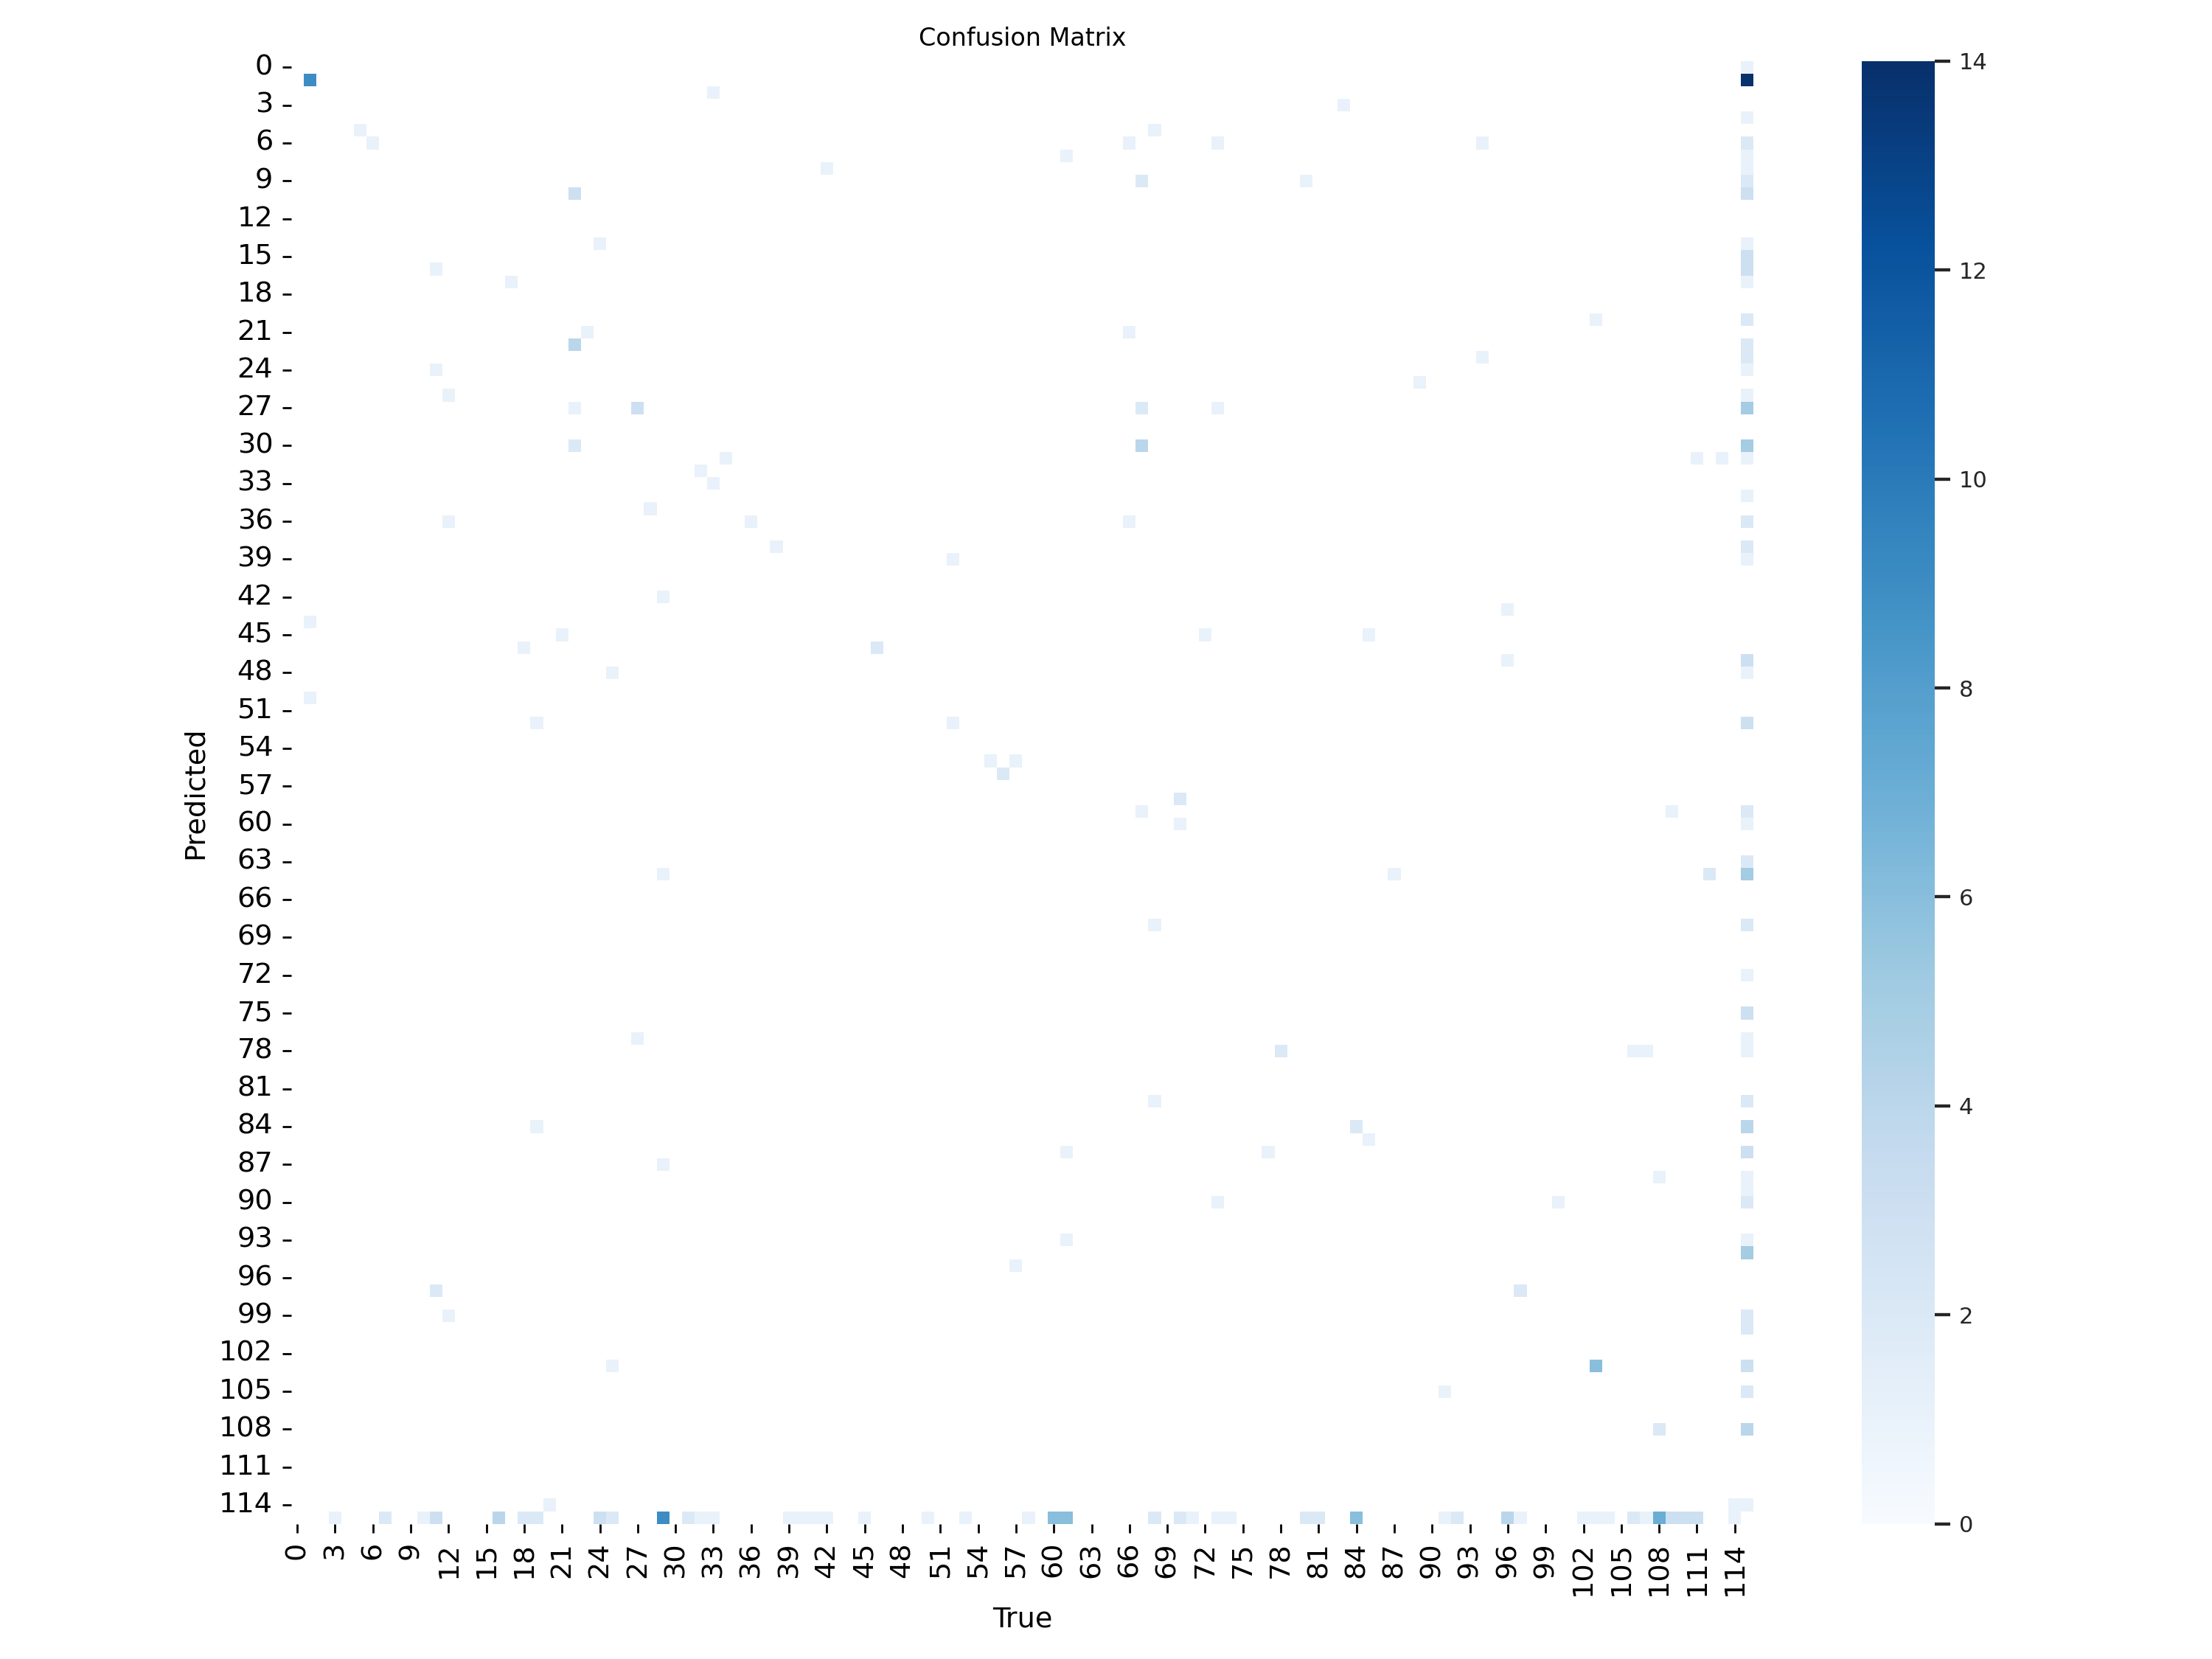

In [19]:
from IPython.display import Image

Image(filename=f'runs/detect/train5/confusion_matrix.png', width=1000)

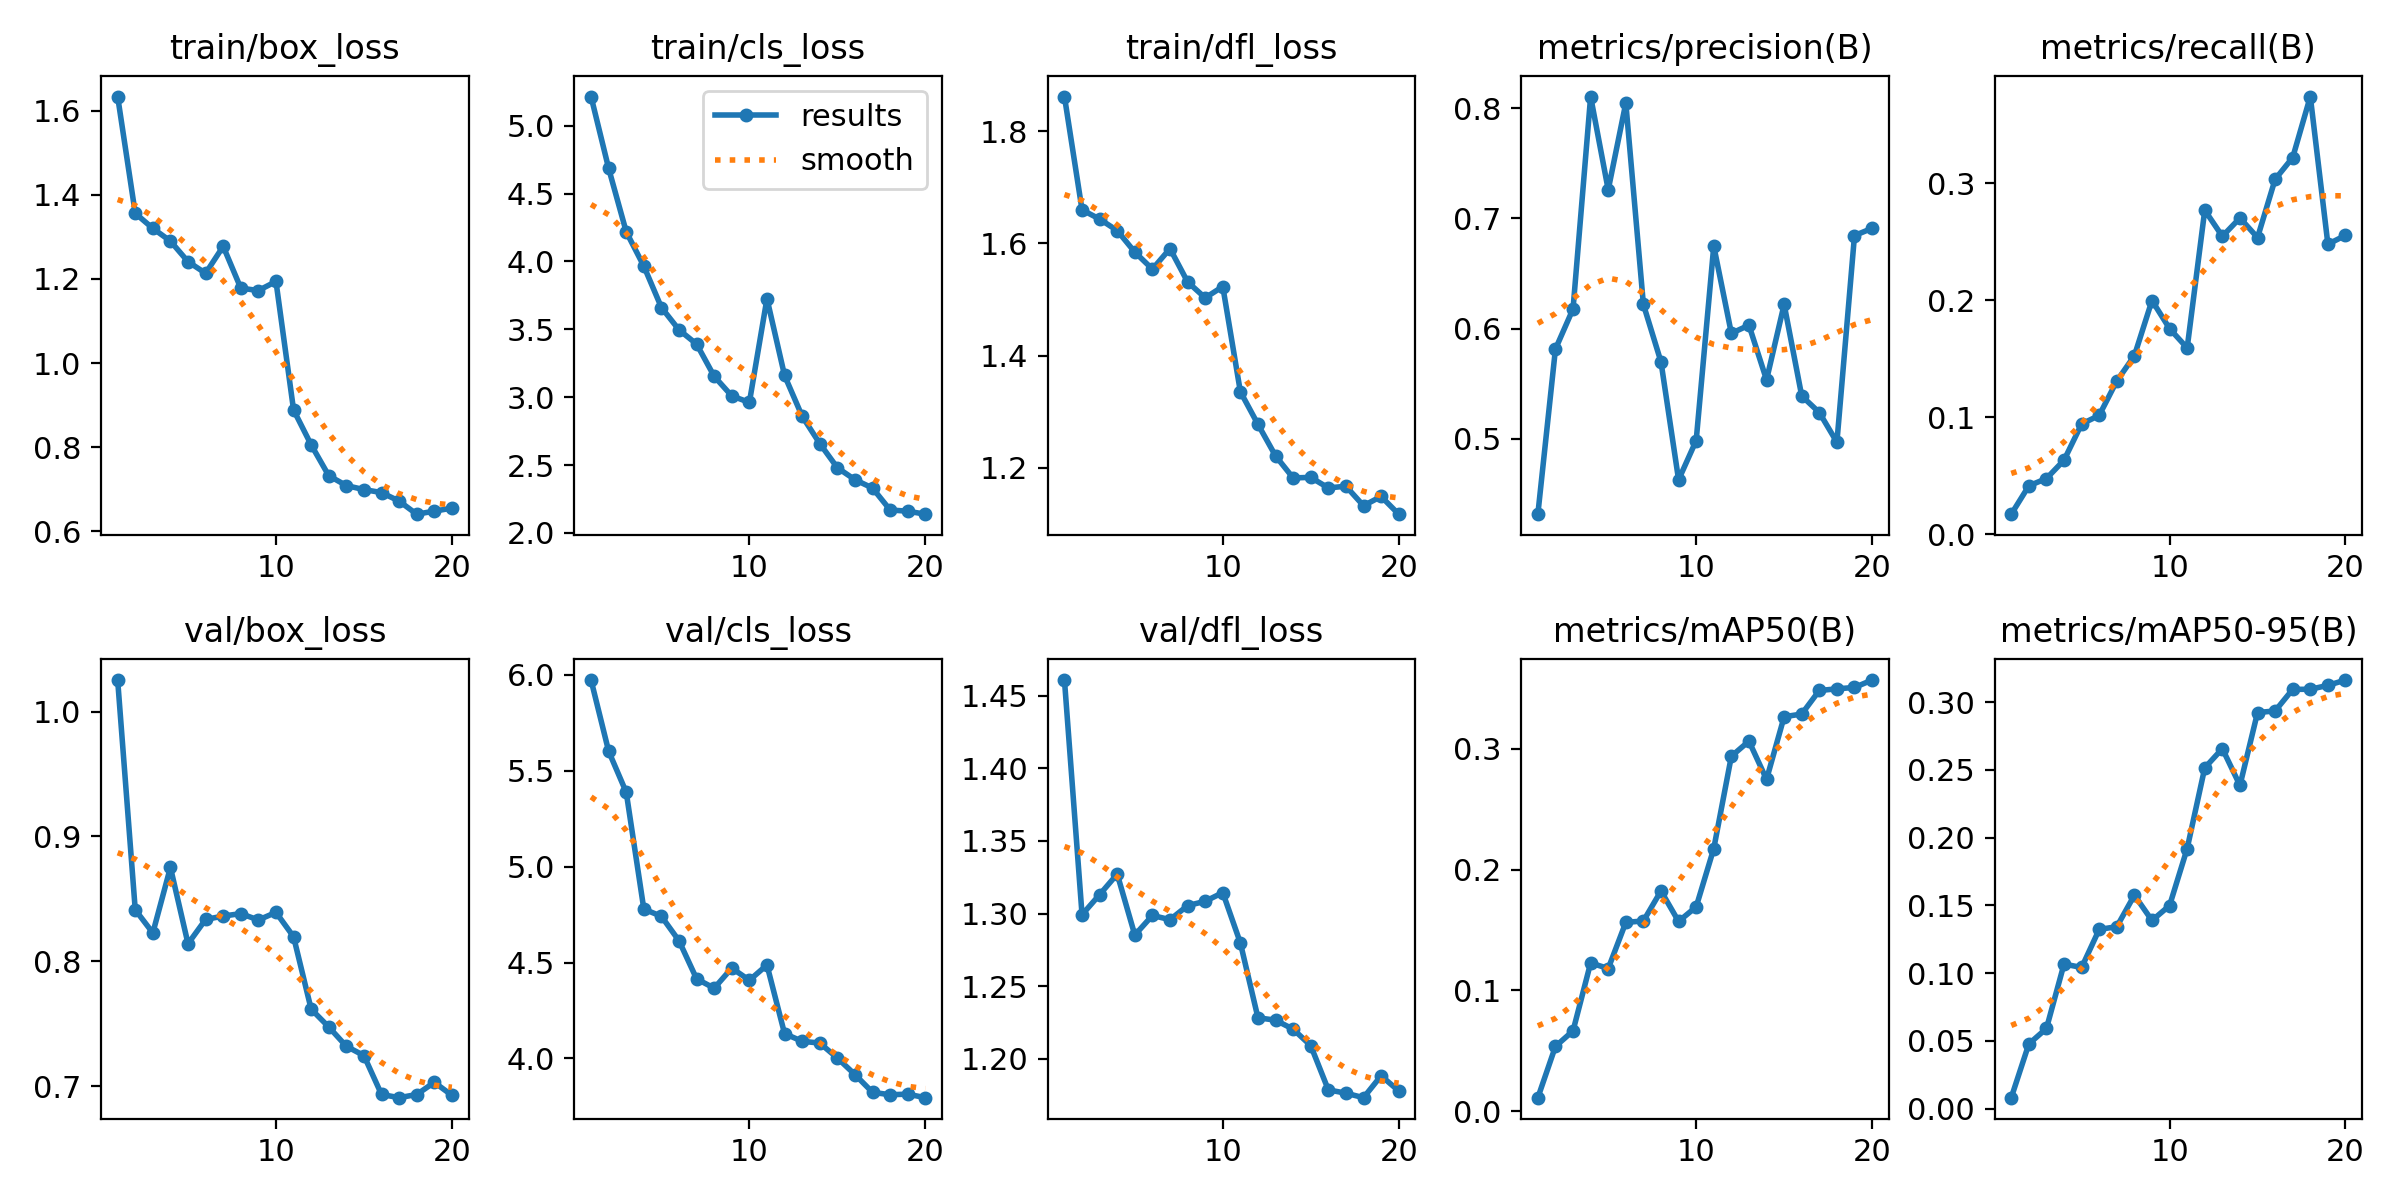

In [20]:
from IPython.display import Image

Image(filename=f'runs/detect/train5/results.png', width=1000)

In [22]:
'''
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

'''

'\nimport supervision as sv\n\nds = sv.DetectionDataset.from_yolo(\n    images_directory_path=f"{dataset.location}/test/images",\n    annotations_directory_path=f"{dataset.location}/test/labels",\n    data_yaml_path=f"{dataset.location}/data.yaml"\n)\n\nds.classes\n\n'